### ChatGPT Sentiment analysis

The objective of this work is to analyze the sentiment of tweets regarding ChatGPT and how it has evolved over the last 3 months. 
The dataset used contains almost 500,000 tweets from January 4, 2023, untill March 29, 2023.

In [1]:
# Import Libraries
import numpy as np
import pandas as pd
import seaborn as sns
import re
import nltk
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from matplotlib import pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from textblob import TextBlob
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS
from collections import Counter
from datetime import datetime

In [2]:
tweets = pd.read_csv('data/TwitterJanMar.csv')
tweets.head(5)

,date,content,username
0,2023-03-29 22:58:21+00:00,"Free AI marketing and automation tools, strate...",RealProfitPros
1,2023-03-29 22:58:18+00:00,@MecoleHardman4 Chat GPT says it’s 15. 😂,AmyLouWho321
2,2023-03-29 22:57:53+00:00,https://t.co/FjJSprt0te - Chat with any PDF!\n...,yjleon1976
3,2023-03-29 22:57:52+00:00,"AI muses: ""In the court of life, we must all f...",ChatGPT_Thinks
4,2023-03-29 22:57:26+00:00,Most people haven't heard of Chat GPT yet.\nFi...,nikocosmonaut


In [3]:
tweets = tweets.drop(['id', 'like_count', 'retweet_count'], axis=1)


In [4]:
tweets.to_csv('modified_tweets.csv', index=False)

In [5]:
tweets.head()

,date,content,username
0,2023-03-29 22:58:21+00:00,"Free AI marketing and automation tools, strate...",RealProfitPros
1,2023-03-29 22:58:18+00:00,@MecoleHardman4 Chat GPT says it’s 15. 😂,AmyLouWho321
2,2023-03-29 22:57:53+00:00,https://t.co/FjJSprt0te - Chat with any PDF!\n...,yjleon1976
3,2023-03-29 22:57:52+00:00,"AI muses: ""In the court of life, we must all f...",ChatGPT_Thinks
4,2023-03-29 22:57:26+00:00,Most people haven't heard of Chat GPT yet.\nFi...,nikocosmonaut


In [4]:
print('Amount of tweets: ',tweets.content.nunique())
print('Last tweet on '+tweets['date'][0],' and First tweet on ', tweets['date'].iloc[-1])

Amount of tweets:  493744
Last tweet on 2023-03-29 22:58:21+00:00  and First tweet on  2023-01-04 07:16:56+00:00


In [5]:
tweets.shape # I see 500036 rows, but 493744 unique tweets.

(500036, 6)

In [6]:
tweets.drop_duplicates(subset='content', inplace=True)

In [7]:
tweets.dtypes

date              object
id                object
content           object
username          object
like_count       float64
retweet_count    float64
dtype: object

In [8]:
# Import functions
def data_report(df):
    '''FUNCION QUE DEFINE UN REPORTE DEL DATAFRAME'''
    # Sacamos los NOMBRES
    cols = pd.DataFrame(df.columns.values, columns=["COL_N"])

    # Sacamos los TIPOS
    types = pd.DataFrame(df.dtypes.values, columns=["DATA_TYPE"])

    # Sacamos los MISSINGS
    percent_missing = round(df.isnull().sum() * 100 / len(df), 2)
    percent_missing_df = pd.DataFrame(percent_missing.values, columns=["MISSINGS (%)"])

    # Sacamos los VALORES UNICOS
    unicos = pd.DataFrame(df.nunique().values, columns=["UNIQUE_VALUES"])
    
    percent_cardin = round(unicos['UNIQUE_VALUES']*100/len(df), 2)
    percent_cardin_df = pd.DataFrame(percent_cardin.values, columns=["CARDIN (%)"])

    concatenado = pd.concat([cols, types, percent_missing_df, unicos, percent_cardin_df], axis=1, sort=False)
    concatenado.set_index('COL_N', drop=True, inplace=True)


    return concatenado.T

In [9]:
data_report(tweets)

COL_N,date,id,content,username,like_count,retweet_count
DATA_TYPE,object,object,object,object,float64,float64
MISSINGS (%),0.0,0.0,0.0,0.01,0.01,0.01
UNIQUE_VALUES,469817,493736,493744,247997,1047,481
CARDIN (%),95.15,100.0,100.0,50.23,0.21,0.1


In [10]:
tweets.isnull().sum()


date              0
id                1
content           1
username         28
like_count       40
retweet_count    40
dtype: int64

In [11]:
tweets.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 493745 entries, 0 to 500035
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   date           493745 non-null  object 
 1   id             493744 non-null  object 
 2   content        493744 non-null  object 
 3   username       493717 non-null  object 
 4   like_count     493705 non-null  float64
 5   retweet_count  493705 non-null  float64
dtypes: float64(2), object(4)
memory usage: 26.4+ MB


In [12]:
# drop rows with null values in the 'content' column
tweets.dropna(subset=['content'], inplace=True)

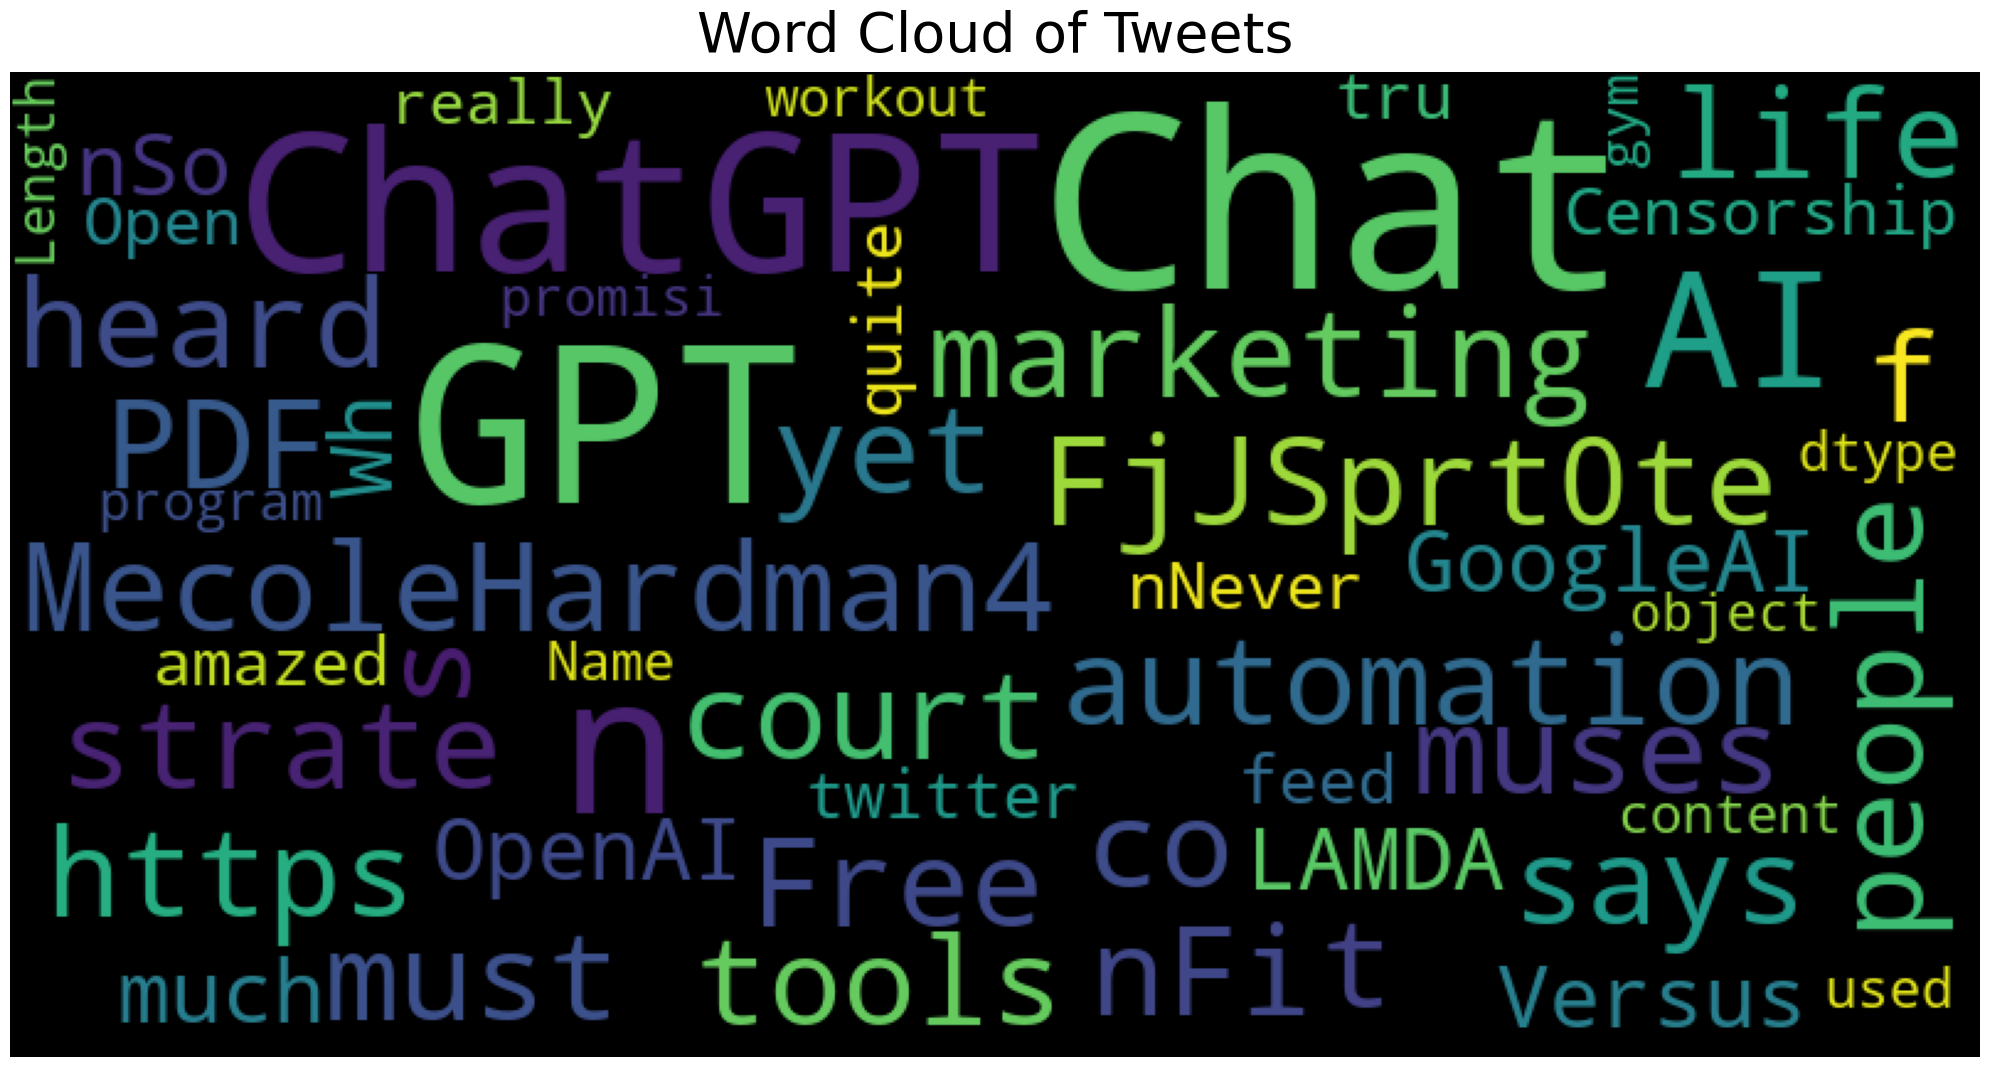

In [13]:
# Wordcloud WITHOUT any cleaning

from wordcloud import WordCloud, STOPWORDS

def plot_wordcloud(text, mask=None, max_words=200, max_font_size=100, figure_size=(20.0,12.0), 
                   title = None, title_size=40, image_color=False):
    stopwords = set(STOPWORDS)
    more_stopwords = {'br', 'Po', 'th', 'sayi', 'fo', 'Unknown'}
    stopwords = stopwords.union(more_stopwords)

    wordcloud = WordCloud(background_color='black',
                    stopwords = stopwords,
                    max_words = max_words,
                    max_font_size = max_font_size, 
                    random_state = 42,
                    width=800, 
                    height=400,
                    mask = mask)
    wordcloud.generate(str(text))
    
    plt.figure(figsize=figure_size)
    if image_color:
        image_colors = ImageColorGenerator(mask);
        plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear");
        plt.title(title, fontdict={'size': title_size,  
                                  'verticalalignment': 'bottom'})
    else:
        plt.imshow(wordcloud);
        plt.title(title, fontdict={'size': title_size, 'color': 'black', 
                                  'verticalalignment': 'bottom'})
    plt.axis('off');
    plt.tight_layout()  
    
plot_wordcloud(tweets["content"], title="Word Cloud of Tweets")

In [14]:
tweets['username'].value_counts()

Ben_Ccarter      1620
richardkimphd    1598
MidJourneyAI_    1221
JimyTuits        1008
PDH_Metaverse     868
                 ... 
derek_morgen        1
Van_Haals           1
mike_tempest        1
arnabing            1
pnik91              1
Name: username, Length: 247997, dtype: int64

### TOP 5: Most Mentioned Users in Tweets

In [15]:
#tweets = tweets.reset_index(drop=True)

# Regular expression to extract user mentions from tweet content
pattern = re.compile(r'@(\w+)')

# List to store all user mentions
mentions = []

# Iterate over tweets and extract user mentions
for tweet in tweets['content']:
    mentions.extend(pattern.findall(tweet))

# Count occurrences of each user mention
mention_counts = Counter(mentions)

# Find the top 3 most mentioned users and their counts
top_mentioned_users = mention_counts.most_common(5)

# Print the results
for i, (user, count) in enumerate(top_mentioned_users):
    print(f"The #{i+1} most mentioned user is {user} with {count} mentions.")



The #1 most mentioned user is OpenAI with 15198 mentions.
The #2 most mentioned user is elonmusk with 8674 mentions.
The #3 most mentioned user is ChatGPT with 4048 mentions.
The #4 most mentioned user is YouTube with 3084 mentions.
The #5 most mentioned user is Microsoft with 2818 mentions.


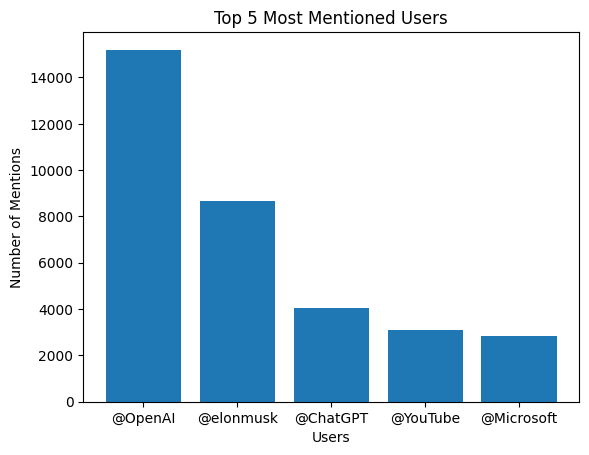

In [16]:
# Regular expression to extract user mentions from tweet content
pattern = re.compile(r'@(\w+)')

# List to store all user mentions
mentions = []

# Iterate over tweets and extract user mentions
for tweet in tweets['content']:
    mentions.extend(pattern.findall(tweet))

# Count occurrences of each user mention
mention_counts = Counter(mentions)

# Get the top 5 most mentioned users and their counts
top_mentions = mention_counts.most_common(5)

# Create a bar chart of the top 5 most mentioned users
x_labels = [f"@{mention[0]}" for mention in top_mentions]
y_values = [mention[1] for mention in top_mentions]
plt.bar(x_labels, y_values)
plt.title("Top 5 Most Mentioned Users")
plt.xlabel("Users")
plt.ylabel("Number of Mentions")
plt.show()



## Let the cleaning begin!

In [17]:
# remove symbols
signos = re.compile("(\.)|(\;)|(\:)|(\!)|(\?)|(\,)|(\")|(\')|(\()|(\))|(\[)|(\])|(\{)|(\})|(\*)|(\+)|(\=)|(\-)|(\&)|(\|)|(\#)|(\@)|(\$)|(\%)|(\^)|(\~)|(\`)|(\d+)"
)

def signs_tweets(tweet):
    return signos.sub('', tweet.lower())

tweets['content_bck'] = tweets['content']
tweets['content'] = tweets['content'].apply(signs_tweets)
tweets['content'].head()

0    free ai marketing and automation tools strateg...
1                  mecolehardman chat gpt says it’s  😂
2    https//tco/fjjsprtte  chat with any pdf\ncheck...
3    ai muses in the court of life we must all face...
4    most people havent heard of chat gpt yet\nfirs...
Name: content, dtype: object

In [18]:
# remove stopwords

nltk.download('stopwords')
stop_words = stopwords.words('english')

def remove_stopwords(text):
    """
    Remove stopwords from text.
    """
    # Tokenize text
    tokens = nltk.word_tokenize(text)
    # Remove stopwords
    tokens = [token for token in tokens if token.lower() not in stop_words]
    # Join tokens back into string
    return ' '.join(tokens)

tweets['content'] = tweets['content'].apply(remove_stopwords)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/agustingerome/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [19]:
# Removes links

def remove_links(df):
    return " ".join(['{link}' if ('http') in word else word for word in df.split()])

tweets['content'] = tweets['content'].apply(remove_links)

In [20]:
# Removes mentions (@user) 
def remove_mentions(text):
    return re.sub(r'@[A-Za-z0-9_]+', '', text)

tweets['content'] = tweets['content'].apply(remove_mentions)


In [21]:
tweets.content

0         free ai marketing automation tools strategies ...
1                           mecolehardman chat gpt says ’ 😂
2         {link} chat pdf check new ai quickly answers q...
3         ai muses court life must face judge destiny ju...
4         people havent heard chat gpt yet first elite f...
                                ...                        
500031    googleai lamda versus openai chatgpt cares lam...
500032    chatgpt much censorship never trust system don...
500033         twitter feed chatgpt openai lol 😆 ai chatgpt
500034    im quite amazed chat gpt really promising pers...
500035    used chat gpt get gym workout program good sor...
Name: content, Length: 493744, dtype: object

### Categorizing tweets into POSITIVE, NEGATIVE and NEUTRAL
To avoid relying on only one method, I'll use two: TextBlob and Sentiment Intensity Analyzer.   
I'll calculate the mean of both polarities and then categorize the results as 'Positive', 'Negative', or 'Neutral'.

## TextBLOB

In [22]:

sentiment = lambda x: TextBlob(x).sentiment.polarity
tweets['TB_sentiment'] = tweets['content'].apply(sentiment)


In [23]:
tweets['TB_sentiment']

0         0.268182
1         0.000000
2         0.342424
3         0.000000
4         0.041667
            ...   
500031    0.212500
500032    0.200000
500033    0.800000
500034    0.200000
500035    0.700000
Name: TB_sentiment, Length: 493744, dtype: float64

### Sentiment Intensity Analyzer

In [24]:
analyzer = SentimentIntensityAnalyzer()
sentiment = lambda x: analyzer.polarity_scores(x)['compound']
tweets['SIA_sentiment'] = tweets['content'].apply(sentiment)

In [25]:
tweets['SIA_sentiment']

0         0.5106
1         0.0000
2         0.7184
3         0.0000
4         0.0258
           ...  
500031    0.6705
500032   -0.4023
500033    0.4215
500034    0.7569
500035    0.1027
Name: SIA_sentiment, Length: 493744, dtype: float64

### Mean of Both Columns

In [26]:

tweets['mean_sentiment'] = (tweets['SIA_sentiment'] + tweets['TB_sentiment']) / 2

In [27]:
tweets['mean_sentiment']

0         0.389391
1         0.000000
2         0.530412
3         0.000000
4         0.033733
            ...   
500031    0.441500
500032   -0.101150
500033    0.610750
500034    0.478450
500035    0.401350
Name: mean_sentiment, Length: 493744, dtype: float64

### Let´s Replace Numbers with feelings:
**-> Positive tweets >= 0.03**  
**-> Neutral tweets between -0.03 and 0.03**  
**-> Negative tweets <= 0.03**

In [28]:
tweets.reset_index(drop=True, inplace=True)

for i in range(len(tweets)):
    if tweets.loc[i, 'mean_sentiment'] >= 0.03:
        tweets.loc[i, 'sentiment'] = 'Positive'
    elif -0.03 < tweets.loc[i, 'mean_sentiment'] < 0.03:
        tweets.loc[i, 'sentiment'] = 'Neutral'
    elif tweets.loc[i, 'mean_sentiment'] <= -0.03:
        tweets.loc[i, 'sentiment'] = 'Negative'


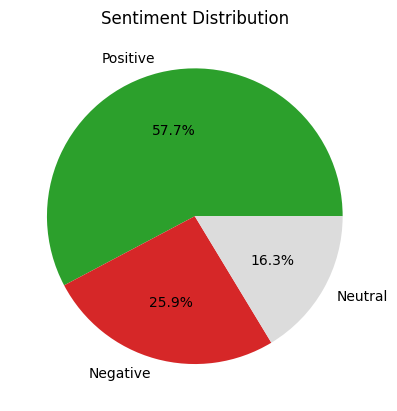

In [29]:
# Count the number of tweets in each sentiment category
sentiment_count = tweets['sentiment'].value_counts()

# Define the labels and colors for each sentiment category
sentiment_labels = ['Positive', 'Negative', 'Neutral']
sentiment_colors = ['#2ca02c', '#d62728', '#dcdcdc']


# Plot a pie chart
plt.pie(sentiment_count, labels=sentiment_labels, colors=sentiment_colors, autopct='%1.1f%%')

# Add a title
plt.title('Sentiment Distribution')

# Show the plot
plt.show()

### Wordclouds display the most frequently used words in Positive, Neutral and Negative tweets
('ChatGPT', 'Chat', 'GPT', 'link', 'AI', and 'OpenAI' have been excluded from the analysis.)

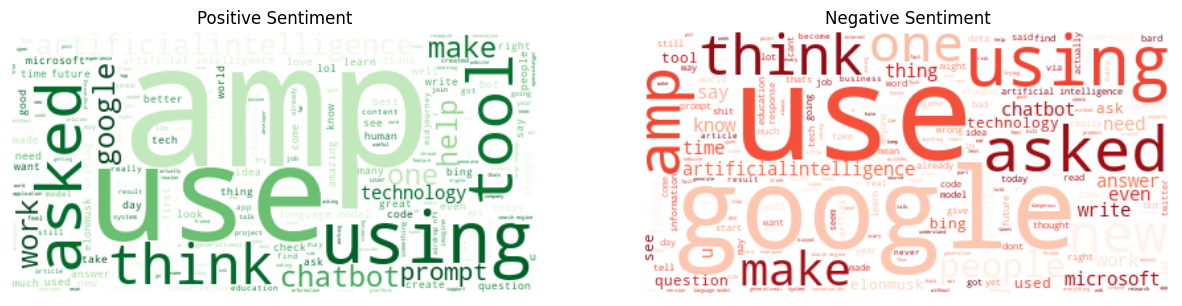

In [35]:
# Define stopwords
stopwords = set(STOPWORDS)
stopwords.update(['chatgpt', 'chat', 'gpt', 'link', 'ai', 'openai'])

# Create a WordCloud object for positive sentiment tweets
positive_tweets = tweets[tweets['sentiment'] == 'Positive']
positive_text = " ".join(review for review in positive_tweets['content'])
positive_cloud = WordCloud(stopwords=stopwords, background_color='white', colormap='Greens').generate(positive_text)

# Create a WordCloud object for negative sentiment tweets
negative_tweets = tweets[tweets['sentiment'] == 'Negative']
negative_text = " ".join(review for review in negative_tweets['content'])
negative_cloud = WordCloud(stopwords=stopwords, background_color='white', colormap='Reds').generate(negative_text)

# Create subplots for the wordclouds
fig, ax = plt.subplots(1, 2, figsize=(15, 8))
ax[0].imshow(positive_cloud, interpolation='bilinear')
ax[0].set_title('Positive Sentiment')
ax[0].axis('off')
ax[1].imshow(negative_cloud, interpolation='bilinear')
ax[1].set_title('Negative Sentiment')
ax[1].axis('off')
plt.show()


### Now, let´s see the evolution of this comments according to date posted.

In [31]:
# Convert the 'date' column to datetime type
tweets['date'] = pd.to_datetime(tweets['date'], errors='coerce')

# Use forward fill to fill in missing values
tweets['date'] = tweets['date'].fillna(method='ffill')

# Create a new column with only month and day
tweets['month_day'] = tweets['date'].dt.strftime('%m-%d')

In [32]:
tweets['month_day']

0         03-29
1         03-29
2         03-29
3         03-29
4         03-29
          ...  
493739    01-04
493740    01-04
493741    01-04
493742    01-04
493743    01-04
Name: month_day, Length: 493744, dtype: object

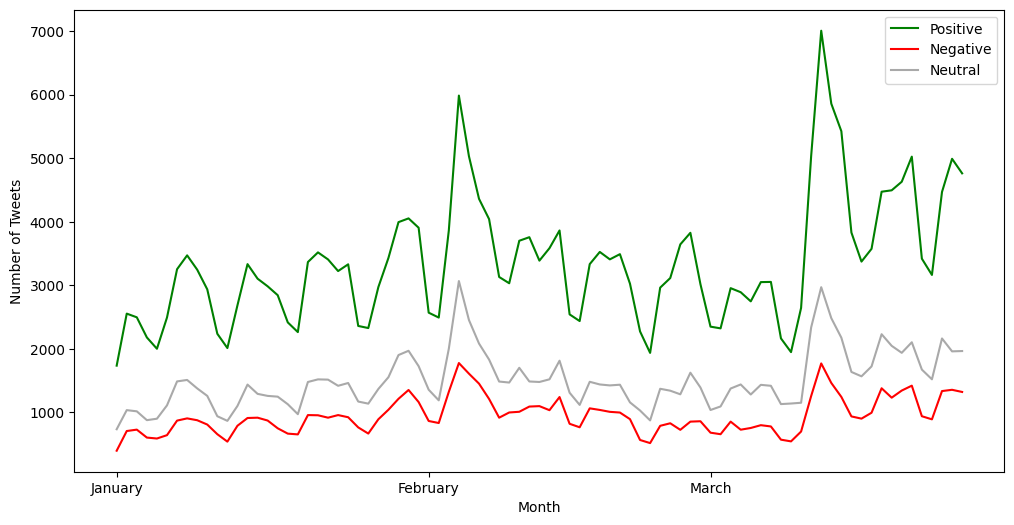

In [33]:
# Group tweets by sentiment and month_day, then sum the values
grouped_tweets = tweets.groupby(['sentiment', 'month_day']).size().reset_index(name='count')

# Separate the groups into separate DataFrames
positive_tweets = grouped_tweets[grouped_tweets['sentiment'] == 'Positive']
negative_tweets = grouped_tweets[grouped_tweets['sentiment'] == 'Negative']
neutral_tweets = grouped_tweets[grouped_tweets['sentiment'] == 'Neutral']

# Convert month_day to datetime format
grouped_tweets['month_day'] = pd.to_datetime(grouped_tweets['month_day'], format='%m-%d')

# Create the line graph
plt.plot(positive_tweets['month_day'], positive_tweets['count'], color='green', label='Positive')
plt.plot(negative_tweets['month_day'], negative_tweets['count'], color='red', label='Negative')
plt.plot(neutral_tweets['month_day'], neutral_tweets['count'], color='darkgrey', label='Neutral')

# Format x-axis labels to show only the month name
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%B'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())

# Add labels and legend
plt.xlabel('Month')
plt.ylabel('Number of Tweets')
plt.legend()

# Show the graph
plt.gcf().set_size_inches(12, 6)  # Set figure size to be wider
plt.show()


### What about those 2 peaks?

In [34]:
# Find the maximum y values and their corresponding dates
max_counts = grouped_tweets.groupby(['sentiment'])['count'].max()
max_count_dates = [grouped_tweets.loc[(grouped_tweets['sentiment'] == sentiment) & 
                                      (grouped_tweets['count'] == max_counts[sentiment]), 
                                      'month_day'].values[0] for sentiment in max_counts.index]
# Convert the max_count_dates to a set to remove duplicates
max_count_dates = list(set(max_count_dates))

for date in max_count_dates:
    date_str = np.datetime_as_string(date, unit='D')
    dt = datetime.strptime(date_str, '%Y-%m-%d')
    print(dt.strftime('%B %d'))


February 07
March 15


### February 07:
#### Microsoft announcement:
https://blogs.microsoft.com/blog/2023/02/07/reinventing-search-with-a-new-ai-powered-microsoft-bing-and-edge-your-copilot-for-the-web/

### March 15:
#### Openai launch gpt-4:
https://openai.com/research/gpt-4